In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import time


#from skbio.diversity import alpha_diversity
#from skbio.diversity import beta_diversity
#from skbio import TreeNode
from io import StringIO
#from skbio.stats.ordination import pcoa
from skbio.stats.composition import ancom
import math
from skbio.stats.composition import multiplicative_replacement
import numpy as np

from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.model_selection import KFold

import cx_Oracle

SERVER = 'dboracle.itk.ppke.hu'
PORT = 1521
SERVICE = 'rsc.itk.ppke.hu'
USER = 'metagenome'
PASSWORD = 'LrJPRUS73r84'

class Connection():

    def __init__(self):
        dsn_tns = cx_Oracle.makedsn(SERVER, PORT, service_name=SERVICE)
        self.connection = cx_Oracle.connect(USER, PASSWORD, dsn_tns)

    def get_connection(self):
        return self.connection

    def select(self, sql):
        return pd.read_sql(sql, con=self.connection)

con = Connection()

In [29]:
def ROC(df):
    TPR_list = []
    FPR_list = []
    df["TARGET"] = df["STUDY_CONDITION"] != "CRC"

    min_bal = df["Balance"].min()
    max_bal = df["Balance"].max()
    step = (max_bal-min_bal) / 100
    for treshold in np.arange(min_bal, max_bal, step):
        df["PREDICATE"] = [i>treshold for i in df["Balance"]]

        TP = len(df.loc[(df["PREDICATE"] == True )&
                                (df["TARGET"] == True)])
        FP = len(df.loc[(df["PREDICATE"] == True )&
                                (df["TARGET"] == False)])
        FN = len(df.loc[(df["PREDICATE"] == False )&
                                (df["TARGET"] == True)])
        TN = len(df.loc[(df["PREDICATE"] == False )&
                                (df["TARGET"] == False)])

        TPR = TP / (TP+FN)
        FPR = FP / (TN+FP)

        TPR_list.append(TPR)
        FPR_list.append(FPR)

    return FPR_list, TPR_list

In [22]:
dataset_name1, dataset_name2, method, rank = "FengQ_2015","VogtmannE_2016","metaphlan2", "p"
path_to_files = "data/" + "_".join(["from", dataset_name1, "to", dataset_name2, method, rank])
path_to_balance = "_".join([path_to_files, "balance.csv"])
path_to_y = "_".join([path_to_files, "y.csv"])
print(path_to_balance)
data = pd.read_csv(path_to_balance, delimiter = '\t')
y = pd.read_csv(path_to_y, delimiter = '\t')

data/from_FengQ_2015_to_VogtmannE_2016_metaphlan2_p_balance.csv


In [23]:
data.head()

,x
1,4.694178
2,4.680884
3,4.772886
4,4.696254
5,4.211643


In [13]:
data = data.join(y, lsuffix = "_data", rsuffix="_y")

In [45]:
def get_results(dataset_name, method, rank):
    path_to_files = "data/" + "_".join([dataset_name, method, rank])
    path_to_balance = "_".join([path_to_files, "balance.csv"])
    path_to_y = "_".join([path_to_files, "y.csv"])
    
    data = pd.read_csv(path_to_balance, delimiter = '\t')
    y = pd.read_csv(path_to_y, delimiter = '\t')
    
    y = y.reset_index()
    data = data.reset_index()

    data = data.join(y, lsuffix = "_data", rsuffix="_y")

    data["STUDY_CONDITION"] = data["x_y"]
    data["Balance"] = data["x_data"]
    
    #ROC görbe számolása
    fpr, tpr = ROC(data)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title( dataset_name + ", " + method + ', ' + rank)
    plt.legend(loc="lower right")
    
    plt.savefig("_".join([path_to_files, "ROC.png"]))
    

In [39]:
def compare_results(dataset_name1, dataset_name2, method, rank):
    path_to_files = "data/" + "_".join(["from", dataset_name1, "to", dataset_name2, method, rank])
    path_to_balance = "_".join([path_to_files, "balance.csv"])
    path_to_y = "_".join([path_to_files, "y.csv"])
    
    data = pd.read_csv(path_to_balance, delimiter = '\t')
    y = pd.read_csv(path_to_y, delimiter = '\t')
    
    y = y.reset_index()
    data = data.reset_index()

    data = data.join(y, lsuffix = "_data", rsuffix="_y")

    data["STUDY_CONDITION"] = data["x_y"]
    data["Balance"] = data["x_data"]
    
    #ROC görbe számolása
    fpr, tpr = ROC(data)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title( 'Features from ' + dataset_name1+ " used on " + dataset_name2 + ", " + method + ', ' + rank)
    plt.legend(loc="lower right")
    
    plt.savefig("_".join([path_to_files, "ROC.png"]))
    

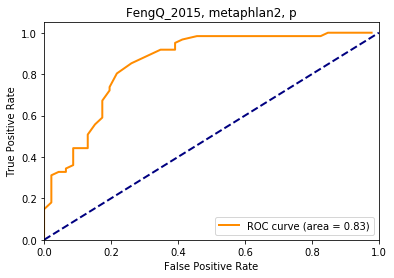

In [46]:
get_results("FengQ_2015", "metaphlan2", "p")

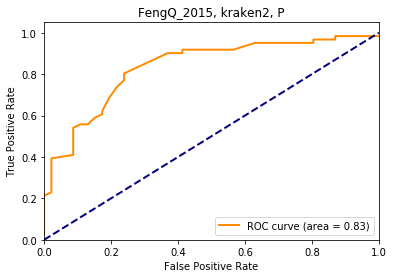

In [53]:
get_results("FengQ_2015", "kraken2", "P")

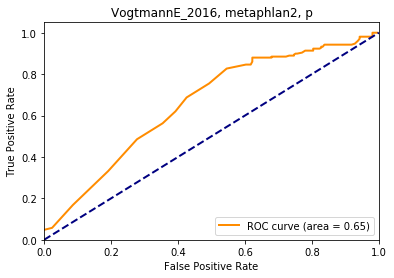

In [54]:
get_results("VogtmannE_2016", "metaphlan2", "p")

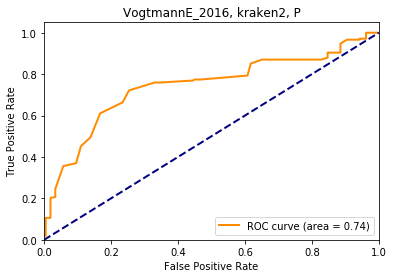

In [56]:
get_results("VogtmannE_2016", "kraken2", "P")

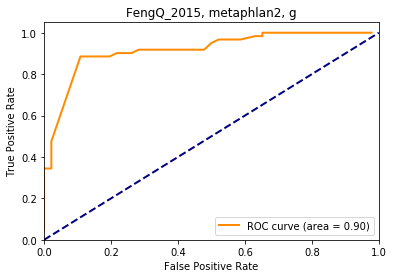

In [65]:
get_results("FengQ_2015", "metaphlan2", "g")

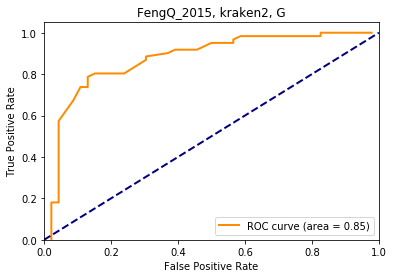

In [58]:
get_results("FengQ_2015", "kraken2", "G")

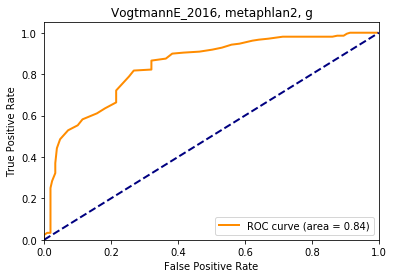

In [64]:
get_results("VogtmannE_2016", "metaphlan2", "g")

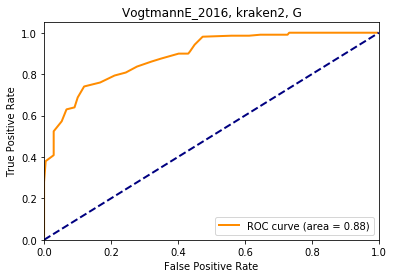

In [59]:
get_results("VogtmannE_2016", "kraken2", "G")

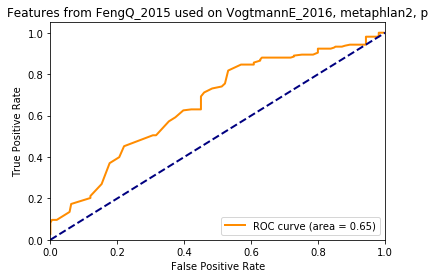

In [40]:
compare_results("FengQ_2015", "VogtmannE_2016","metaphlan2", "p")

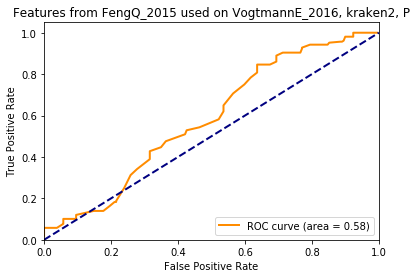

In [77]:
compare_results("FengQ_2015", "VogtmannE_2016","kraken2", "P")

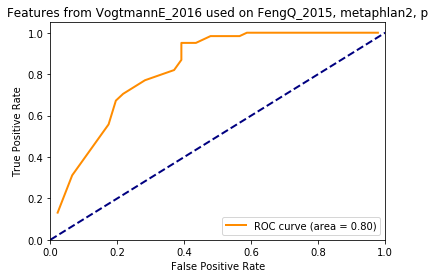

In [41]:
compare_results( "VogtmannE_2016","FengQ_2015","metaphlan2", "p")

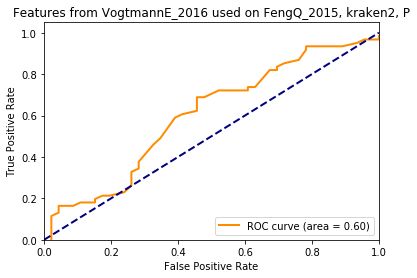

In [67]:
compare_results("VogtmannE_2016", "FengQ_2015","kraken2", "P")

In [74]:
compare_results("FengQ_2015", "VogtmannE_2016",  "kraken2", "P")

FileNotFoundError: File b'data/from_FengQ_2015_to_VogtmannE_2016_kraken2_P_balance.csv' does not exist

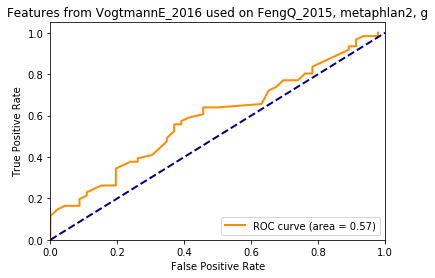

In [82]:
compare_results("VogtmannE_2016", "FengQ_2015", "metaphlan2", "g")

In [80]:
compare_results("VogtmannE_2016", "FengQ_2015", "metaphlan2", "g")

FileNotFoundError: File b'data/from_VogtmannE_2016_to_FengQ_2015_metaphlan2_g_balance.csv' does not exist

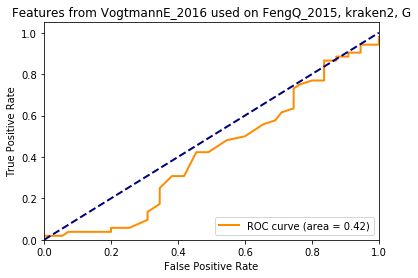

In [72]:
compare_results("VogtmannE_2016", "FengQ_2015", "kraken2", "G")

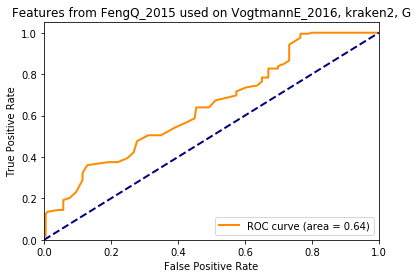

In [73]:
compare_results("FengQ_2015","VogtmannE_2016",  "kraken2", "G")

In [83]:
compare_results("FengQ_2015","ZellerG_2014",  "kraken2", "P")
compare_results("VogtmannE_2016","ZellerG_2014",  "kraken2", "P")

compare_results("FengQ_2015","ZellerG_2014",  "metaphlan2", "p")
compare_results("VogtmannE_2016","ZellerG_2014",  "metaphlan2", "p")

compare_results("FengQ_2015","ZellerG_2014",  "kraken2", "G")
compare_results("VogtmannE_2016","ZellerG_2014",  "kraken2", "G")

compare_results("FengQ_2015","ZellerG_2014",  "metaphlan2", "g")
compare_results("VogtmannE_2016","ZellerG_2014",  "metaphlan2", "g")

FileNotFoundError: File b'data/from_FengQ_2015_to_ZellerG_2014_kraken2_P_balance.csv' does not exist